## Cavapa Data Processing

This script is written to assist in the validation study of CAVAPA. CAVAPA is a tool for Computer Assisted Video Analysis of Physical Activity.

<https://cavapa.ruthenbeck.io>

CAVAPA is a project at Finland's JYU university with Heidi Pasi and the 
FidiPro team with Prof. Taru Lintunen and Prof. Martin Hagger
Greg Ruthenbeck. 26.5.21

CAVAPA data is compared with other data:
Heart-Rate, Accelerometer, and manually observed (SOPLAY)

Import the `cavapa.py` python helpers.

In [117]:
from cavapa import *

### Indoor (Gym)

#### Pre-process Heart-rate data 

Copy data from personal recordings into a single CSV with 1 column for each person.

In [118]:
gymHrData = {}
for i in range(1,8): # 7 good data files. 1 not available
 	data = getScoresFromTimeLevels(readHeartRateRawCSV(f'input/gym-hr-person{i}.csv'))
 	data = downSample(data, 10) # convert 1Hz to 0.1Hz
 	gymHrData[f'Person{i}'] = data[:120]
writeDictToCSV('output/gym-hr.csv', 'CAVAPA JYU. Greg Ruthenbeck. 20min @0.1Hz (10s intervals).', gymHrData)

#### Read Observational Scores from CSV

- Sampling rate: `0.1Hz (10s intervals)`
- Example of CSV row: `10,00:01:40,0.1.2.1`, the 10th sample, time, count of 0 people activity-level-1, 1 at level #2, etc

In [119]:
# 0.1Hz (10s intervals)
gymHrData = readHeartRateCSV('output/gym-hr.csv')

def offsetSeries(data, offset): # Offset HR data for better correlations
    data = data[offset:]
    for i in range(0,offset): # append to same length as prior by copying last value
        data.append(data[len(data) - 1])
    return data

gymHr2Data = offsetSeries(gymHrData, 1) # left-shift the HR data 10s for better correlation
# 0.1Hz (10s intervals)
gymObsData1 = getScoresFromTimeLevels(readTimeLevelsCSV('input/gym-observed1.csv'))
# Read and convert CSV-file's 0.2Hz (5s intervals) to 0.1Hz (10s intervals)
gymObsData2 = downSample(readSimpleCSV('input/gym-obs2-5s.csv'), 2)
gymAccData  = downSample(readSimpleCSV('input/gym-acc-5s.csv'), 2)
# Read and convert 25Hz (25fps) to 0.1Hz (10s interval)
gymCavData = readSimple2ColCSV('input/gym-cavapa-cameraA.csv', 25, 10)
gymData = {
	'Cav': 	gymCavData,
	'Acc': 	gymAccData,
	'HR': 	gymHrData,
	'HR*': 	gymHr2Data,
	'Obs1': gymObsData1,
	'Obs2': gymObsData2
}
gymData = trimToSameLen(gymData, 120)

Skipping CSV line  1 :  ['FrameID', ' MovementScore']


Generate the charts

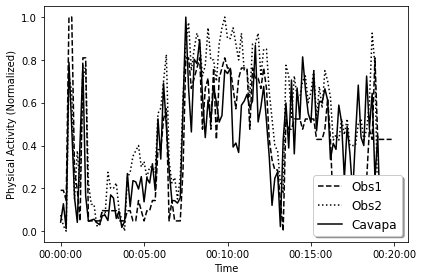

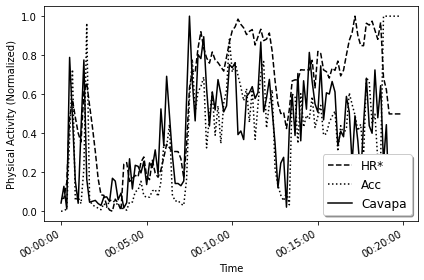

In [120]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Zeros at the end of the series messes up normalization. Trim off the zeros
gymAdjusted = trimToSameLen({'Obs1': gymData['Obs1'][:115], 'Obs2': gymData['Obs2'][:115]}, 120)

fig, axs = plt.subplots(1, 1)
t = pd.date_range('2020-01-01', periods=len(gymData['Obs1']), freq='10s')
axs.plot(t, normalize(gymAdjusted['Obs1'],0,1), 'k--', label='Obs1')
axs.plot(t, normalize(gymAdjusted['Obs2'],0,1), 'k:', label='Obs2')
axs.plot(t, normalize(gymData['Cav'],0,1), 'k', label='Cavapa')
axs.set_xlabel('Time')
axs.set_ylabel('Physical Activity (Normalized)')
xfmt = mdates.DateFormatter('%H:%M:%S')
axs.xaxis.set_major_formatter(xfmt)
axs.legend(loc='lower right', shadow=True, fontsize='large')
fig.tight_layout()
plt.savefig('output/plots/cavapa_gym_obs.png', dpi=100) # must be before show()
plt.show()

fig, axs = plt.subplots(1, 1)
axs.plot(t, normalize(gymData['HR*'],0,1), 'k--', label='HR*')
axs.plot(t, normalize(gymData['Acc'],0,1), 'k:', label='Acc')
axs.plot(t, normalize(gymData['Cav'],0,1), 'k', label='Cavapa')
axs.set_xlabel('Time')
axs.set_ylabel('Physical Activity (Normalized)')
fig.autofmt_xdate()
xfmt = mdates.DateFormatter('%H:%M:%S')
axs.xaxis.set_major_formatter(xfmt)
axs.legend(loc='lower right', shadow=True, fontsize='large')
fig.tight_layout()
plt.savefig('output/plots/cavapa_gym_hr_acc.png', dpi=100) # must be before show()
plt.show()


In [128]:


writeDictToCSV('output/gym.csv', 'CAVAPA JYU. Greg Ruthenbeck. 20min @0.1Hz (10s intervals).', gymData)

gymData = trimToSameLen(gymData, 116) # remove last few samples because no participants are visible
# print('Gym Correlations, Pearsons, Spearmans')
# printCorrelation({ k: gymData[k] for k in ['Obs1', 'Obs2'] })

print('Gym Correlations')
gymCorr = pd.DataFrame.from_dict(gymData).corr()
gymCorr.style.format("{:.2f}").set_caption("Study 1. Indoor Correlations")



Gym Correlations


,Cav,Acc,HR,HR*,Obs1,Obs2
Cav,1.00,0.62,0.57,0.70,0.74,0.80
Acc,0.62,1.00,0.72,0.76,0.67,0.66
HR,0.57,0.72,1.00,0.96,0.53,0.64
HR*,0.70,0.76,0.96,1.00,0.63,0.72
Obs1,0.74,0.67,0.53,0.63,1.00,0.90
Obs2,0.80,0.66,0.64,0.72,0.90,1.00


### Outdoor data (Kilpinen School)

#### Read Observational Scores from CSV

- Sampling rate: `0.1Hz (10s intervals)`
- Example of TimeLevelCSV row: `10,00:01:40,0.1.2.1`, the 10th sample, time, 0 level #1, 1 level #2, etc

In [122]:
kilpObs1Data = getScoresFromTimeLevels(
	      readTimeLevelsCSV('input/kilp-observed1.csv'))
kilpObs2Data = readSimpleCSV('input/kilp-observed2.csv')

#### Read CAVAPA scores

- Sampling rate: `25Hz (25fps)`
- Example of CSV row: `1,0.000`, the 1st sample, the CAVAPA movement score (0 - 1E8)

In [123]:
kilpCavData = downSample(getScoresFromTimeLevels(
		  readSimpleCSV('input/kilp-cavapa.csv')), 25 * 10)

In [133]:
kilpData = {
	'Obs1': kilpObs1Data,
	'Obs2': kilpObs2Data,
	'Cav': kilpCavData
}
kilpData = trimToSameLen(kilpData)
writeDictToCSV('output/kilp.csv', 'CAVAPA JYU. Greg Ruthenbeck. 40min @0.1Hz (10s intervals).', kilpData)

# print('Outdoor Correlations, Pearsons, Spearmans')
# printCorrelation({ k: kilpData[k] for k in ['Obs1', 'Obs2'] })

kilpCorr = pd.DataFrame.from_dict(kilpData).corr()
kilpCorr.style.format("{:.2f}").set_caption("Study 2. Outdoor Correlations")

,Obs1,Obs2,Cav
Obs1,1.00,0.96,0.60
Obs2,0.96,1.00,0.60
Cav,0.60,0.60,1.00


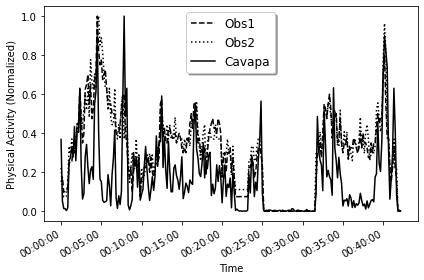

In [125]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

fig, axs = plt.subplots(1, 1)
t = pd.date_range('2020-01-01', periods=len(kilpData['Obs1']), freq='10s')
axs.plot(t, normalize(kilpData['Obs1'],0,1), 'k--', label='Obs1')
axs.plot(t, normalize(kilpData['Obs2'],0,1), 'k:', label='Obs2')
axs.plot(t, normalize(kilpData['Cav'],0,1), 'k', label='Cavapa')
axs.set_xlabel('Time')
axs.set_ylabel('Physical Activity (Normalized)')
fig.autofmt_xdate()
xfmt = mdates.DateFormatter('%H:%M:%S')
axs.xaxis.set_major_formatter(xfmt)
axs.legend(loc='upper center', shadow=True, fontsize='large')
fig.tight_layout()
plt.savefig('output/plots/cavapa_kilp_obs.png', dpi=100) # must be before show()
plt.show()


### Indoor (Gym) Cameras


In [132]:
# Read and convert 25Hz (25fps) to 1Hz (1s interval)
gymViewsCompareData = {
	'CamA': readSimple2ColCSV('input/cavapa/gym-cavapa-CameraA.csv', 25, 1),
	'CamB': readSimple2ColCSV('input/cavapa/gym-cavapa-CameraB.csv', 25, 1),
	'CamC': readSimple2ColCSV('input/cavapa/gym-cavapa-CameraC.csv', 25, 1),
	'CamD': readSimple2ColCSV('input/cavapa/gym-cavapa-CameraD.csv', 25, 1),
	'CamE': readSimple2ColCSV('input/cavapa/gym-cavapa-CameraE.csv', 25, 1),
}
gymViewsCompareData = trimToSameLen(gymViewsCompareData)
writeDictToCSV('output/gym-cemeras.csv', 'CAVAPA JYU. Greg Ruthenbeck. 20min @1Hz (1s intervals).', gymViewsCompareData)
# print('Gym Views-Compare Correlations, Pearsons, Spearmans')
# printCorrelation({ k: gymViewsCompareData[k] for k in ['CamA', 'CamB'] })

gymViewsCorr = pd.DataFrame.from_dict(gymViewsCompareData).corr()
gymViewsCorr.style.format("{:.2f}").set_caption("Study 1. Indoor: Camera Correlations")

Skipping CSV line  1 :  ['FrameID', ' MovementScore']
Skipping CSV line  1 :  ['FrameID', ' MovementScore']
Skipping CSV line  1 :  ['FrameID', ' MovementScore']
Skipping CSV line  1 :  ['FrameID', ' MovementScore']
Skipping CSV line  1 :  ['FrameID', ' MovementScore']


,CamA,CamB,CamC,CamD,CamE
CamA,1.00,0.98,0.97,0.80,0.99
CamB,0.98,1.00,0.97,0.82,0.98
CamC,0.97,0.97,1.00,0.85,0.97
CamD,0.80,0.82,0.85,1.00,0.81
CamE,0.99,0.98,0.97,0.81,1.00
